In [0]:
import torch
import torchvision
import numpy as np
import time
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load 128x128 Data

In [0]:
train_data_dir = '/content/drive/My Drive/WF_Test_Split/train'
test_data_dir = '/content/drive/My Drive/WF_Test_Split/test'

def load_labels(data_dir):
    dsets = {x: datasets.ImageFolder((data_dir))
             for x in ['train']}  
    return (dsets['train'].classes) 
  
classes = load_labels(train_data_dir)

train_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Pytorch's ImageFolder class allows us to read data in the format it's in
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transforms)

# Use's the datasets we just made to make DataLoaders for the networks input
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2,
                                           pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2,
                                         shuffle=True)

# Load 64x64 Data

In [0]:
train_data_dir = '/content/drive/My Drive/WF_Test_Split/train'
test_data_dir = '/content/drive/My Drive/WF_Test_Split/test'

def load_labels(data_dir):
    dsets = {x: datasets.ImageFolder((data_dir))
             for x in ['train']}  
    return (dsets['train'].classes) 
  
classes = load_labels(train_data_dir)

train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Pytorch's ImageFolder class allows us to read data in the format it's in
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transforms)

# Use's the datasets we just made to make DataLoaders for the networks input
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2,
                                           pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2,
                                         shuffle=True)

Display some data

Cephalopholis_miniata Echeneis_naucrates


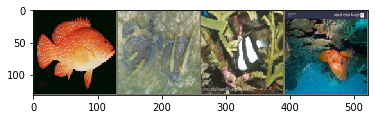

In [0]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

def imshow(img):
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    unorm(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.rcParams["axes.grid"] = False
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

# 128x128 Models

In [0]:
# Five conv 128
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),\
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=(6,6), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2))
    self.layer2 = nn.Sequential(

        nn.Linear(in_features=43264, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4))
                  
                  
  def forward(self, x):
    x = self.layer1(x)
    x = x.reshape(x.size(0), -1)
    #print(x.size())
    x = self.layer2(x)
    
    return x
    
net = Net().cuda()
net.train()
device = torch.device("cuda:0")

In [0]:
# 4 Conv 128
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),\
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(128, 128, kernel_size=(6,6), stride=(1,1), padding=(1,1)),
        nn.ReLU())
    self.layer2 = nn.Sequential(
        nn.Linear(in_features=12800, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4))
                  
                  
  def forward(self, x):
    x = self.layer1(x)
    x = x.reshape(x.size(0), -1)
    #print(x.size())
    x = self.layer2(x)
    
    return x
    
net = Net().cuda()
net.train()
device = torch.device("cuda:0")

In [0]:
# 3 Conv 128
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=6, stride=2),
        nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),\
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=6, stride=2),
        nn.Conv2d(64, 128, kernel_size=(5,5), stride=(1,1), padding=(1,1)),
        nn.ReLU())
        
    self.layer2 = nn.Sequential(
        nn.Linear(in_features=80000, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4))
                  
                  
  def forward(self, x):
    x = self.layer1(x)
    x = x.reshape(x.size(0), -1)
    #print(x.size())
    x = self.layer2(x)
    
    return x
    
net = Net().cuda()
net.train()
device = torch.device("cuda:0")

# 64x64 Models

In [0]:
# 5 Conv 64
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),\
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=(6,6), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2))
    self.layer2 = nn.Sequential(

        nn.Linear(in_features=6400, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4))
                  
                  
  def forward(self, x):
    x = self.layer1(x)
    x = x.reshape(x.size(0), -1)
    #print(x.size())
    x = self.layer2(x)
    
    return x
    
net = Net().cuda()
net.train()
device = torch.device("cuda:0")

In [0]:
# 4 Conv 64
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),\
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.ReLU())
    self.layer2 = nn.Sequential(
        nn.Linear(in_features=8192, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4))
                      
  def forward(self, x):
    x = self.layer1(x)
    x = x.reshape(x.size(0), -1)
    #print(x.size())
    x = self.layer2(x)
    return x
    
net = Net().cuda()
net.train()
device = torch.device("cuda:0")

In [0]:
# 3 Conv 64
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=6, stride=2),
        nn.Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),\
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=6, stride=2),
        nn.Conv2d(64, 128, kernel_size=(5,5), stride=(1,1), padding=(1,1)),
        nn.ReLU())
        
    self.layer2 = nn.Sequential(
        nn.Linear(in_features=10368, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=4))
                  
                  
  def forward(self, x):
    x = self.layer1(x)
    x = x.reshape(x.size(0), -1)
    #print(x.size())
    x = self.layer2(x)
    
    return x
    
net = Net().cuda()
net.train()
device = torch.device("cuda:0")

In [0]:
net.train()

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=12800, out_features=4096,

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
loss_list = []
start_time = time.time()
for epoch in range(10): # loop over the dataset multiple times

    running_loss = 0.0
    running_loss2 = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('Finished Training')
print('Time:', time.time() - start_time)

Finished Training
Time: 37.95341157913208


In [0]:
net.eval()

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=12800, out_features=4096,

For testing the model on test data.

In [0]:
totalCorrect = 0
total = 0
class_pred = []
total_groundtruth = []

net.to(device)
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        actualPred = outputs
        for i in range(2):
          tensorList = actualPred[i].cpu()
          tensorList = tensorList.numpy()
          labelsList = labels[i].cpu()
          labelsList = labelsList.numpy()
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1
          total_groundtruth.append(labelsList.max())
          class_pred.append(tensorList.argmax())

for i in range(4):
    totalCorrect += class_correct[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    total += class_total[i]
    print(class_correct[i],class_total[i])
    overall_accuracy = 100*totalCorrect/total
print("\nTesting Accuracy = {0:.2f}".format(overall_accuracy))
print(classification_report(total_groundtruth,class_pred,target_names = classes))
    

Accuracy of Cephalopholis_miniata : 86 %
20.0 23.0
Accuracy of Dascyllus_aruanus : 93 %
15.0 16.0
Accuracy of Echeneis_naucrates : 100 %
18.0 18.0
Accuracy of Genicanthus_melanospilos : 92 %
12.0 13.0

Testing Accuracy = 92.86
                          precision    recall  f1-score   support

   Cephalopholis_miniata       1.00      0.87      0.93        23
       Dascyllus_aruanus       0.94      0.94      0.94        16
      Echeneis_naucrates       0.86      1.00      0.92        18
Genicanthus_melanospilos       0.92      0.92      0.92        13

                accuracy                           0.93        70
               macro avg       0.93      0.93      0.93        70
            weighted avg       0.93      0.93      0.93        70



For testing the models on training data.

In [0]:
totalCorrect = 0
total = 0
class_pred = []
total_groundtruth = []

net.to(device)
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        actualPred = outputs
        #print('c',c)
        #print('actualpred', actualPred)
        #print('labels',labels)
        for i in range(4):
          tensorList = actualPred[i].cpu()
          tensorList = tensorList.numpy()
          labelsList = labels[i].cpu()
          labelsList = labelsList.numpy()
          #print(tensorList)
          #print(labels)
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1
          total_groundtruth.append(labelsList.max())
          class_pred.append(tensorList.argmax())

for i in range(4):
    totalCorrect += class_correct[i]
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    total += class_total[i]
    print(class_correct[i],class_total[i])
    
print("\nTraining Accuracy = ",100*totalCorrect/total)

    

Accuracy of Cephalopholis_miniata : 87 %
79.0 90.0
Accuracy of Dascyllus_aruanus : 96 %
58.0 60.0
Accuracy of Echeneis_naucrates : 98 %
68.0 69.0
Accuracy of Genicanthus_melanospilos : 81 %
40.0 49.0

Training Accuracy =  91.41791044776119


Plotting loss curves.

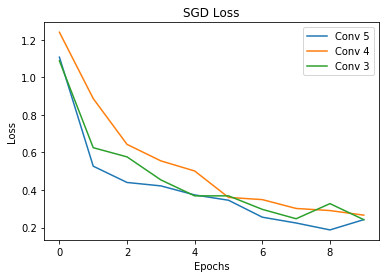

In [0]:
epochs = [1,2,3,4,5,6,7,8,9,10]
conv5 = [1.1078058255206253, 0.5269269118964893, 0.44017709719647263, 
          0.42193668615419183, 0.3737562518137538, 0.345443583332473,
          0.2551171591290754, 0.22414258443733132, 0.18730146822876204, 
          0.24210307301198683]
conv4 = [1.2408288127870808, 0.8873102150885146, 0.6430860336828409, 
          0.5552084889110579, 0.5013907341265768, 0.36055510615770703, 
          0.3488018111668555, 0.3016405916568515, 0.29045571381274654, 
          0.2659852646540532]
conv3 = [1.0884952749018333, 0.6255141385869023, 0.5765160237989461, 
         0.45384467490100505, 0.36873068197952324, 0.3688658759496469, 
         0.2967768389053061, 0.24683946570499235, 0.3273977958579932, 
         0.2419028782933175]

#fig = plt.figure()
ax = plt.subplot(111)
ax.plot(conv5, label='Conv 5')
ax.plot(conv4, label='Conv 4')
ax.plot(conv3, label='Conv 3')
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.title('SGD Loss')
ax.legend()
plt.show()
